核心概念（Core Concepts）
-------------------------

参考[Core
Concepts](https://radimrehurek.com/gensim/auto_examples/core/run_core_concepts.html)，[Corpora
and Vector
Spaces](https://tedboy.github.io/nlps/gensim_tutorial/tut1.html)，[Topics
and
Transformations](https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html)。

### 文档（Document）

一段字符串。

``` python
document = "Human machine interface for lab abc computer applications"
```

### 语料库（Corpus）

Corpus指一组Document。

-   原始

    ``` python
    text_corpus = [
        "Human machine interface for lab abc computer applications",
        "A survey of user opinion of computer system response time",
        "The EPS user interface management system",
        "System and human system engineering testing of EPS",
        "Relation of user perceived response time to error measurement",
        "The generation of random binary unordered trees",
        "The intersection graph of paths in trees",
        "Graph minors IV Widths of trees and well quasi ordering",
        "Graph minors A survey",
    ]
    ```

-   基本处理

    一般的行为有：

    -   分词：对于英文来说，相对比较简单，而对于中文则复杂的多。
    -   去除stopwords
    -   删除低频词

    ``` python
    from pprint import pprint

    # Create a set of frequent words
    stoplist = set('for a of the and to in'.split(' '))
    # Lowercase each document, split it by white space and filter out stopwords
    texts = [[word for word in document.lower().split() if word not in stoplist]
             for document in text_corpus]

    # Count word frequencies
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    # Only keep words that appear more than once
    processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
    pprint(processed_corpus)
    ```

    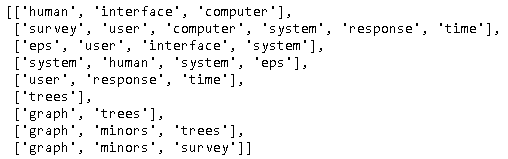-

    对于中文，可以类似这样处理。其中分词采用了[jieba](https://github.com/fxsjy/jieba)。

    ``` shell
    import jieba
    import urllib
    from pprint import pprint

    # 下载停用词
    response = urllib.request.urlopen('https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt')
    stop_words = [str(word[:-1],'utf-8') for word in response.readlines()]

    docs =  ['自然语言处理是计算机科学领域与人工智能领域中的一个重要方向。',
         '它研究能实现人与计算机之间用自然语言进行有效通信的各种理论和方法。',
         '自然语言处理是一门融语言学、计算机科学、数学于一体的科学。',
         '因此，这一领域的研究将涉及自然语言，即人们日常使用的语言，',
         '所以它与语言学的研究有着密切的联系，但又有重要的区别。',
         '自然语言处理并不是一般地研究自然语言，',
         '而在于研制能有效地实现自然语言通信的计算机系统，',
         '特别是其中的软件系统。因而它是计算机科学的一部分。']

    corpus = [[word for word in jieba.cut(doc) if word not in stop_words] for doc in docs ]
    pprint(corpus)
    ```

    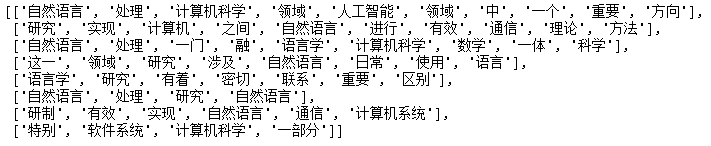

-   向量化

    基本处理后，再把语料库用向量的形式来表达，详见下一节。

### 向量（Vector）

为了能够便于Model的调用，还需要把语料库用向量的形式来表示。而向量化，也意味着语料所占空间大大减少，这样就能处理更大的语料库。

#### 字典（Dictionary）

首先要构建Dictionary，即创建gensim.corpora.dictionary.Dictionary类。

``` python
from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
```

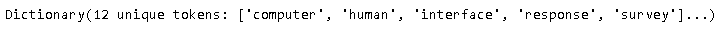

Dictionary非常有用，它的详细描述如下。

-   Attributes
    -   id2token：Reverse mapping for token2id, initialized in a lazy
        manner to save memory (not created until needed).
    -   token2id：token -\> tokenId。
    -   cfs： 每个token出现的频次。
    -   dfs：每个token出现在多少个文档中。
    -   num\_nnz：每篇文档unique word的个数汇总。
    -   num\_docs： 文档数量。
    -   num\_pos：总共多少个word。
-   Methods
    -   doc2bow：把文档转化为BOW格式

下面通过一个简单的例子来体验这些属性和方法。

``` python
from gensim.corpora.dictionary import Dictionary
docs = [
    ["black", "cat", "white", "cat"],
    ["cat", "outer", "space", "cat"],
    ["wag", "dog"]
]

from gensim.corpora.dictionary import Dictionary
dict = Dictionary(docs)

# 由于id2token是lazy manner， 所以先调用任何一个元素，触发生成id2token
print(dict[0])
print("dict.id2token =", dict.id2token)   
print('-'*50)
print("dict.token2id =", dict.token2id)
print('-'*50)
print("dict.cfs =", dict.cfs)           
print('-'*50)
print("dict.dfs =", dict.dfs)           # 
print('-'*50)
print("dict.num_nnz =", dict.num_nnz)
print('-'*50)
print("dict.num_docs =", dict.num_docs)
print('-'*50)
print("dict.num_pos =", dict.num_pos)
print('-'*50)

print("dict.doc2bow(docs[0]) =", dict.doc2bow(docs[0]))
print('-'*50)
print("dict.doc2idx(docs[0]) =", dict.doc2idx(docs[0]))
print('-'*50)
```

结果如下：

``` shell
black
dict.id2token = {0: 'black', 1: 'cat', 2: 'white', 3: 'outer', 4: 'space', 5: 'dog', 6: 'wag'}
--------------------------------------------------
dict.token2id = {'black': 0, 'cat': 1, 'white': 2, 'outer': 3, 'space': 4, 'dog': 5, 'wag': 6}
--------------------------------------------------
dict.cfs = {0: 1, 1: 4, 2: 1, 3: 1, 4: 1, 6: 1, 5: 1}
--------------------------------------------------
dict.dfs = {0: 1, 1: 2, 2: 1, 3: 1, 4: 1, 6: 1, 5: 1}
--------------------------------------------------
dict.num_nnz = 8
--------------------------------------------------
dict.num_docs = 3
--------------------------------------------------
dict.num_pos = 10
--------------------------------------------------
dict.doc2bow(docs[0]) = [(0, 1), (1, 2), (2, 1)]
--------------------------------------------------
dict.doc2idx(docs[0]) = [0, 1, 2, 1]
--------------------------------------------------
```

#### BOW（Bag of Word）

通过统计文档的BOW来，重新构建语料库。

``` python
print(dictionary.token2id)

bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
pprint(bow_corpus)
```

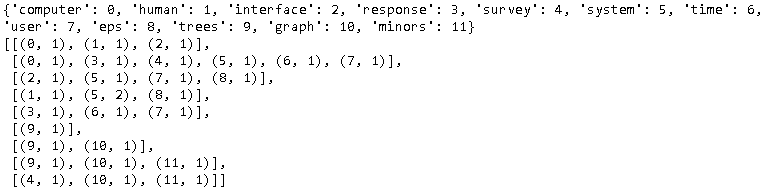

每篇文档由一个向量表示，由于文本的稀疏性，仅仅记录哪些数量大于零的word。

### 模型（Model）

在Gensim，把Model看成是一种转换（Transformation），即把语料库的向量空间（vector
space）转化为模型所在的向量空间。比如：
[tf-idf](https://en.wikipedia.org/wiki/Tf–idf)。它根据word在语料库中的稀缺性对BOW进行加权。

#### tf-idf

``` python
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "system minors".lower().split()
doc = dictionary.doc2bow(words)
print(dod)
print(tfidf[doc])
```

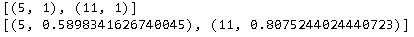

> The tf-idf model transforms vectors from the bag-of-words
> representation to a vector space where the frequency counts are
> weighted according to the relative rarity of each word in the corpus.

进一步可以获得基于tf-idf的语料库。

``` python
tfidf_corpus =  tfidf[bow_corpus]
print('-'*50)
pprint(bow_corpus)
print('-'*50)
pprint([[(id, round(tfidf, 4))for id, tfidf in doc] for doc in tfidf_corpus])
```

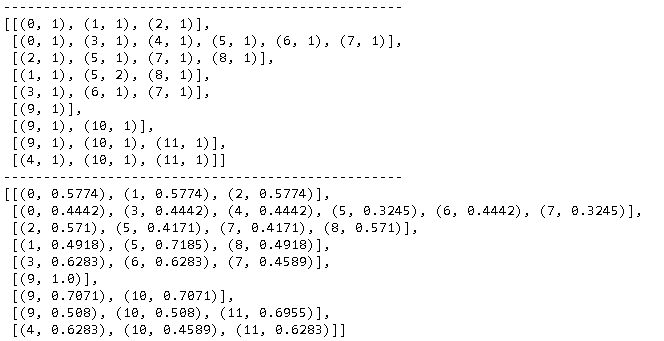

除了tf-idf模型，gensim还支持很多其它模型，比如：LSI（[Latent Semantic
Indexing](https://en.wikipedia.org/wiki/Latent_semantic_indexing)），RP（[Random
Projections](http://www.cis.hut.fi/ella/publications/randproj_kdd.pdf)）,
LDA（[Latent Dirichlet
Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)），HDP（[Hierarchical
Dirichlet
Process](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)）。下面介绍一下LSI。

#### LSI

全称[Latent Semantic Indexing(或 Latent Semantic Analysis
)](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing).
它采用奇异值分解对文档矩阵进行分解。奇异值分解的公式如下： $$
A=USV^\mathrm {T} 
$$ 在LSI中，A是Term-Document文档矩阵（行是Term，列是Document），

``` shell
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)  
corpus_lsi = lsi_model[corpus_tfidf]  
for doc in corpus_tfidf:
    print(doc)
```

> 下面的代码比较了奇异值分解和LSI。
>
> ``` python
> import gensim
> import numpy as np
> from gensim import corpora
> from gensim import models
>
> A = np.array([[1,2,3], [2,0,2]])
> print("A =\n", A)
>
> print('-'*25,  "奇异值分解", '-'*25, sep='')
> U, S, VT = np.linalg.svd(A, full_matrices=False) 
> print("U =\n", U)
> print("S =\n", S)
> print("VT = \n", VT)
>
> # A在U为基所对应的矩阵。即A中每个列向量在以U为基中对应的向量（坐标）
> UTA = U.T @ A
> print("U.T @ A =\n", UTA)
>
> print('-'*25,  "LSI", '-'*25, sep='')
> corpus = gensim.matutils.Dense2Corpus(A)
> lsi = models.LsiModel(corpus)
>
> print("U =\n", lsi.projection.u)
> print("S =\n", lsi.projection.s)
>
> vt =  (lsi.projection.u.T @ A) / lsi.projection.s.reshape(len(lsi.projection.s),1)
> print("VT =\n", vt)
>
> # lsi[corpus] 等价U.T @ A
> new_a = gensim.matutils.corpus2dense(lsi[corpus], num_terms=len(lsi.projection.s))
> print("lsi[corpus] =\n", new_a)
> ```
>
> 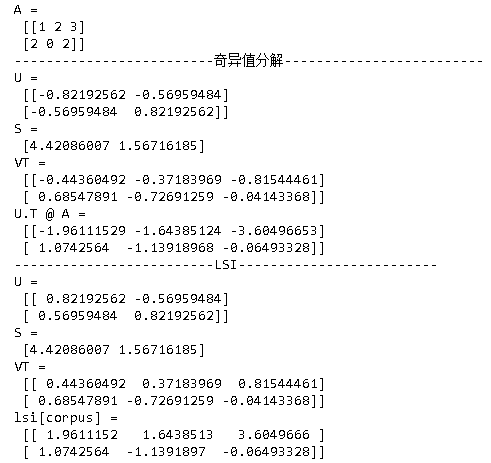
>
> 需要注意：
>
> -   LSI分解出的向量，和奇异值分解出的向量有时方向相反。
> -   *lsi\[corpus\]*
>     等价$U^TA$，可以看成$A$变换到以$U$为基的对应矩阵，即$A$中每个列向量在以$U$为基中对应的向量（坐标）。

### 保存和加载

``` python
import os
import tempfile

with tempfile.NamedTemporaryFile(prefix='model-', suffix='.lsi', delete=False) as tmp:
    lsi_model.save(tmp.name)  # same for tfidf, lda, ...

loaded_lsi_model = models.LsiModel.load(tmp.name)

os.unlink(tmp.name)
```

#### 相似性（Similarity）

接下来，我们就可以进行相似性比较了。比如，下面使用[SparseMatrixSimilarity](https://tedboy.github.io/nlps/generated/generated/gensim.similarities.SparseMatrixSimilarity.html)，它采用cosine
similarity来计算向量之间的相似性。

``` python
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf_corpus, num_features=12)

query_document = 'system engineering'.split()
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]

# 排序
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print((document_number, text_corpus[document_number], score))
```

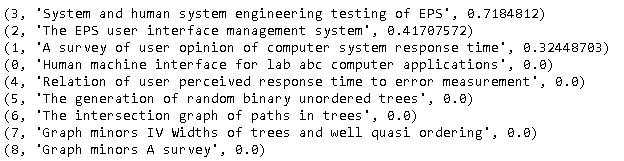

除了[SparseMatrixSimilarity](https://tedboy.github.io/nlps/generated/generated/gensim.similarities.SparseMatrixSimilarity.html)，gensim还包含其它相似性计算的类，比如：[MatrixSimilarity](https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.MatrixSimilarity)，[WmdSimilarity](https://radimrehurek.com/gensim/similarities/docsim.html#gensim.similarities.docsim.WmdSimilarity)。

### Corpus Streaming

上面的例子中，语料库被完整的加载到内存中，然后，实际工作中，语料库往往包含几百万甚至更多的文档，没有办法能够一次加载到内存中来，所以必须要采用Streaming的方式来读取数据。下面是一个例子。

首先创建语料库文件。每一行是一篇文档。

``` shell
mkdir -p data
cat << EOF > data/mycorpus.txt
Human machine interface for lab abc computer applications
A survey of user opinion of computer system response time
The EPS user interface management system
System and human system engineering testing of EPS
Relation of user perceived response time to error measurement
The generation of random binary unordered trees
The intersection graph of paths in trees
Graph minors IV Widths of trees and well quasi ordering
Graph minors A survey
EOF
```

读取语料库，构建Dictionary。采用Streaming的方式来读取原始语料库文件。

``` python
from gensim import corpora
from six import iteritems
from smart_open import open # for transparently opening remote files

dictionary = corpora.Dictionary(line.lower().split() for line in open('data/mycorpus.txt'))

stoplist = set('for a of the and to in'.split(' '))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

# 移除stop words,和只出现一次的words
print("stop_ids =", stop_ids)
print("once_ids =", once_ids)
dictionary.filter_tokens(stop_ids + once_ids) 

# remove gaps in id sequence after words that were removed
dictionary.compactify()  
print(dictionary)
```

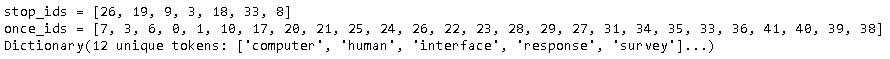

把语料库向量化。每次仅读取一行。

``` python
class MyCorpus(object):
    def __init__(self, file_path='data/mycorpus.txt'):
        self.file_path = file_path
    
    def __len__(self):
        with open(self.file_path) as f:
            for i, _ in enumerate(f):
                pass
        return i + 1
    
    def __iter__(self):
        for line in open(self.file_path):
            yield dictionary.doc2bow(line.lower().split())

corpus_memory_friendly = MyCorpus()  # doesn't load the corpus into memory!
print(corpus_memory_friendly)
for vector in corpus_memory_friendly:  # load one vector into memory at a time
    print(vector)  
```

得到和之前相同的corpus。

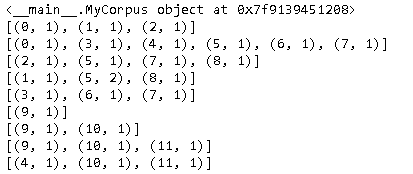

### Corpus格式

gensim可以serialize语料库，支持多种文件格式，比如：[Market Matrix
format](http://math.nist.gov/MatrixMarket/formats.html)，[Joachim’s
SVMlight format](http://svmlight.joachims.org/), [Blei’s LDA-C
format](https://www.cs.princeton.edu/~blei/lda-c/) ，[GibbsLDA++
format](http://gibbslda.sourceforge.net/)。这些格式都是采用Streaming方式加载数据的。

-   保存

    ``` python
    corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus_memory_friendly)
    corpora.SvmLightCorpus.serialize('/tmp/corpus.svmlight', corpus_memory_friendly)
    corpora.BleiCorpus.serialize('/tmp/corpus.lda-c', corpus_memory_friendly)
    corpora.LowCorpus.serialize('/tmp/corpus.low', corpus_memory_friendly)
    ```

-   加载

    ``` python
    print('-'*50)
    corpus = corpora.MmCorpus('/tmp/corpus.mm')
    print(corpus)
    print('-'*50)
    corpus = corpora.SvmLightCorpus('/tmp/corpus.mm')
    print(corpus)
    print('-'*50)
    corpus = corpora.BleiCorpus('/tmp/corpus.mm')
    print(corpus)
    print('-'*50)
    corpus = corpora.LowCorpus('/tmp/corpus.mm')
    print(corpus)

    print('-'*50)
    for doc in corpus:
        print(doc)
    ```

    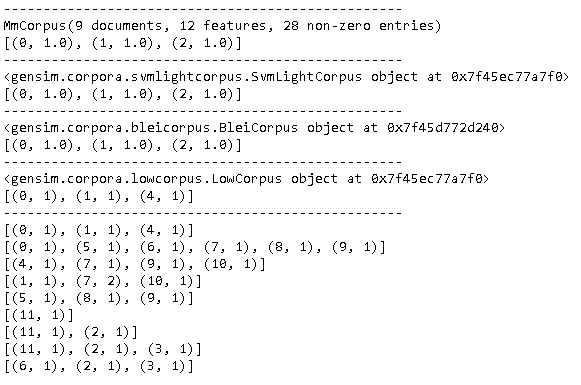

### 兼容NumPy和SciPy

gensim的corpus的格式和Numpy和SciPy中的矩阵并不相同，但可以采用[matutils](https://radimrehurek.com/gensim/matutils.html)进行相互转化。首先看一般的矩阵。

``` python
import gensim
import numpy as np

np.random.seed(20200609)
numpy_matrix = np.random.randint(10, size=[5, 2])  # random matrix as an example
print("numpy_matrix =\n", numpy_matrix)

# 把dense matrix转为为 corpus
corpus = gensim.matutils.Dense2Corpus(numpy_matrix)
print("corpus =",corpus)
for doc in corpus:
    print(doc)

# 把corpus转化为 dense matrix
new_matrix = gensim.matutils.corpus2dense(corpus, num_terms=5)
print("new_matrix =\n", numpy_matrix)
```

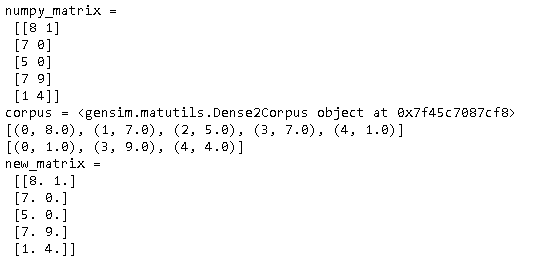

再看稀疏矩阵。

``` python
import gensim
import numpy as np
import scipy.sparse

np.random.seed(20200609)
scipy_sparse_matrix = scipy.sparse.random(5, 2, density=0.6) 
print("scipy_sparse_matrix =\n", scipy_sparse_matrix)

# 把sparse matrix 转化为 corpus
corpus = gensim.matutils.Sparse2Corpus(scipy_sparse_matrix)
print("corpus =", corpus)
for doc in corpus:
    print(doc)

# 把corpus转化为 sparse matrix
new_matrix = gensim.matutils.corpus2csc(corpus)
print("new_matrix =\n", new_matrix)
```

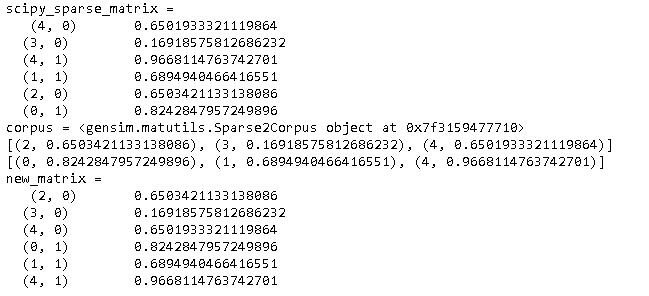

> 需要注意的是corpus转化的矩阵为term-document矩阵，即行代表term，列代表document.

参考
----